In [109]:
import torch
import torch.nn as nn
import numpy as np

In [110]:
class Autoencoder_ConvTranspose(nn.Module):
    def __init__(self):
        super(Autoencoder_ConvTranspose, self).__init__()
        self.channels = [3, 100, 200, 250, 300]
        self.encoder = self.encoder_layers()
        self.decoder = self.decoder_layers()

    def simple_enc_block(self,
                         input_channels: int = 3,
                         output_channels: int = 3,
                         kernel_size: int = 3,
                         padding: int = 1) -> nn.Sequential:
        return nn.Sequential(
            nn.Conv2d(
                in_channels=input_channels,
                out_channels=output_channels,
                kernel_size=kernel_size,
                padding=padding),
            nn.BatchNorm2d(output_channels),
            nn.Dropout(p=0.2),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(kernel_size=2),
            )

    def encoder_layers(self) -> nn.Sequential:
        layers = []
        for i in range(len(self.channels)-1):
            if self.channels[i] != self.channels[-2]:
                layers.append(self.simple_enc_block(
                    input_channels=self.channels[i],
                    output_channels=self.channels[i+1])
                )
            else:
                layers.append(self.simple_enc_block(
                    input_channels=self.channels[i],
                    output_channels=self.channels[i+1])
                )
        return nn.Sequential(*layers)

    def simple_dec_block(self,
                         input_channels: int = 3,
                         output_channels: int = 3,
                         kernel_size: int = 3,
                         stride: int = 2,
                         dilation: int = 1,
                         padding: int = 1,
                         output_padding: int = 1) -> nn.Sequential:
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels=input_channels,
                               out_channels=output_channels,
                               kernel_size=kernel_size,
                               stride=stride,
                               dilation=dilation,
                               padding=padding,
                               output_padding=output_padding,
                            ),
            nn.BatchNorm2d(output_channels),
            nn.Dropout(p=0.2),
            nn.LeakyReLU(0.2)
            )

    def decoder_layers(self) -> nn.Sequential:
        layers = []
        dec_channels = list(reversed(self.channels))
        for i in range(len(dec_channels)-1):
            if dec_channels[i] != dec_channels[-2]:
                layers.append(self.simple_dec_block(
                    input_channels=dec_channels[i],
                    output_channels=dec_channels[i+1])
                )
            else:
                layers.append(self.simple_dec_block(
                    input_channels=dec_channels[i],
                    output_channels=dec_channels[i+1],)
                )
        return nn.Sequential(*layers)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [212]:
class Autoencoder_Initial(nn.Module):
    def __init__(self):
        super(Autoencoder_Initial, self).__init__()
        self.channels = [3, 100, 200, 250, 300]
        self.hidden_state = 1000
        self.encoder = self.encoder_layers()
        self.flatten = nn.Flatten()
        self.lin_neurons = [300, 2, 2]
        self.enc_neurons = np.prod(self.lin_neurons)
        self.linear = nn.Linear(self.enc_neurons,
                                self.hidden_state)
        self.rev_linear = nn.Linear(self.hidden_state,
                                    self.enc_neurons)
        self.decoder = self.decoder_layers()

    def simple_enc_block(self,
                         input_channels: int = 3,
                         output_channels: int = 3,
                         kernel_size: int = 3,
                         stride: int = 2,
                         padding: int = 1,
                         final_layer: bool = False) -> nn.Sequential:
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(in_channels=input_channels,
                          out_channels=output_channels,
                          kernel_size=kernel_size,
                          stride=stride,
                          padding=padding),
                nn.BatchNorm2d(output_channels),
                nn.Dropout(p=0.2),
                nn.LeakyReLU(0.2)
                )
        else:
            return nn.Sequential(
                nn.Conv2d(in_channels=input_channels,
                          out_channels=output_channels,
                          kernel_size=kernel_size,
                          stride=stride,
                          padding=padding)
                )

    def encoder_layers(self) -> nn.Sequential:
        layers = []
        for i in range(len(self.channels)-1):
            if self.channels[i] != self.channels[-2]:
                layers.append(self.simple_enc_block(
                    input_channels=self.channels[i],
                    output_channels=self.channels[i+1]
                ))
            else:
                layers.append(self.simple_enc_block(
                    input_channels=self.channels[i],
                    output_channels=self.channels[i+1],
                    final_layer=True
                    ))
        return nn.Sequential(*layers)

    def simple_dec_block(self,
                         input_channels: int = 3,
                         output_channels: int = 3,
                         kernel_size: int = 4,
                         stride: int = 2,
                         padding: int = 1,
                         final_layer: bool = False) -> nn.Sequential:
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels=input_channels,
                                   out_channels=output_channels,
                                   kernel_size=kernel_size,
                                   stride=stride,
                                   padding=padding),
                nn.BatchNorm2d(output_channels),
                nn.Dropout(p=0.2),
                nn.LeakyReLU(0.2)
                )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels=input_channels,
                                   out_channels=output_channels,
                                   kernel_size=kernel_size,
                                   stride=stride,
                                   padding=padding)
                )

    def decoder_layers(self) -> nn.Sequential:
        layers = []
        dec_channels = list(reversed(self.channels))
        for i in range(len(dec_channels)-1):
            if dec_channels[i] != dec_channels[-2]:
                layers.append(self.simple_dec_block(
                    input_channels=dec_channels[i],
                    output_channels=dec_channels[i+1]
                    ))
            else:
                layers.append(self.simple_dec_block(
                    input_channels=dec_channels[i],
                    output_channels=dec_channels[i+1],
                    final_layer=True
                    ))
        return nn.Sequential(*layers)

    def forward(self, x):
        encoded = self.encoder(x)
        hidden_layer = torch.flatten(encoded, start_dim=1)
        hidden_layer = self.linear(hidden_layer)
        hidden_layer = self.rev_linear(hidden_layer)
        hidden_layer = hidden_layer.view(-1, *self.lin_neurons)
        decoded = self.decoder(hidden_layer)
        return decoded

In [117]:
class Autoencoder_Upsampling(nn.Module):
    def __init__(self):
        super(Autoencoder_Upsampling, self).__init__()
        self.channels = [3, 100, 200, 250, 300]
        self.encoder = self.encoder_layers()
        self.decoder = self.decoder_layers()

    def simple_enc_block(self,
                         input_channels: int = 3,
                         output_channels: int = 3,
                         kernel_size: int = 3,
                         padding: int = 1,
                         maxpool_kernel: int = 2) -> nn.Sequential:
        return nn.Sequential(
            nn.Conv2d(
                in_channels=input_channels,
                out_channels=output_channels,
                kernel_size=kernel_size,
                padding=padding,
            ),
            nn.BatchNorm2d(output_channels),
            nn.Dropout(p=0.2),
            nn.LeakyReLU(0.5),
            nn.MaxPool2d(maxpool_kernel),)

    def encoder_layers(self) -> nn.Sequential:
        layers = []
        for i in range(len(self.channels)-1):
            if self.channels[i] != self.channels[-2]:
                layers.append(self.simple_enc_block(
                    input_channels=self.channels[i],
                    output_channels=self.channels[i+1])
                )
            else:
                layers.append(self.simple_enc_block(
                    input_channels=self.channels[i],
                    output_channels=self.channels[i+1],
                    )
                )
        return nn.Sequential(*layers)

    def simple_dec_block(self,
                         input_channels: int = 3,
                         output_channels: int = 3,
                         kernel_size: int = 1,
                         scale_factor: int = 2,
                         mode: str = 'nearest') -> nn.Sequential:
        return nn.Sequential(
            nn.Upsample(scale_factor=scale_factor, mode=mode),
            nn.Conv2d(
                in_channels=input_channels,
                out_channels=output_channels,
                kernel_size=kernel_size,
            ),
            nn.BatchNorm2d(output_channels),
            nn.Dropout(p=0.2),
            nn.LeakyReLU(0.5)
            )

    def decoder_layers(self) -> nn.Sequential:
        layers = []
        dec_channels = list(reversed(self.channels))
        for i in range(len(dec_channels)-1):
            if dec_channels[i] != dec_channels[-2]:
                layers.append(self.simple_dec_block(
                    input_channels=dec_channels[i],
                    output_channels=dec_channels[i+1])
                )
            else:
                layers.append(self.simple_dec_block(
                    input_channels=dec_channels[i],
                    output_channels=dec_channels[i+1])
                )
        return nn.Sequential(*layers)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [213]:
images = torch.randn(64, 3, 32, 32)
model = Autoencoder_Initial().encoder_layers()
print(model(images).size())
model = Autoencoder_Initial()
print(model(images).size())

torch.Size([64, 300, 2, 2])
torch.Size([64, 3, 32, 32])


In [72]:
3*32*32

3072

In [82]:
20*4*4

320

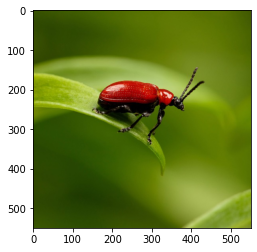

In [133]:
import matplotlib.pyplot as plt
from matplotlib import image
import numpy as np
img = image.imread("/Users/nikolai/Downloads/term-bg-1-c9813571.jpg")
plt.imshow(img)
plt.show()
img = torch.Tensor(np.transpose(img, (2, 0, 1)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


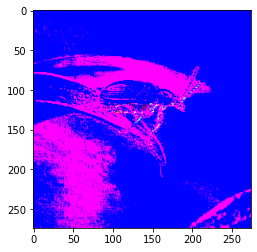

In [207]:
m = nn.Sequential(
    nn.Conv2d(3, 3, 3),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.ReLU(),
)
img_conv = m(img)
plt.imshow(np.transpose(img_conv.detach().numpy(), (1, 2, 0)), cmap='gray')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


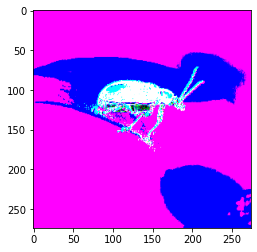

In [192]:
m = nn.Sequential(
    nn.Conv2d(3, 3, 3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
)
img_conv = m(img)
plt.imshow(np.transpose(img_conv.detach().numpy(), (1, 2, 0)))
plt.show()